In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models
from torchmetrics import Accuracy

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

# from lisa import LISA
from itertools import chain
from model import *
from pathlib import Path
from ranger import Ranger

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
normalize = transforms.Normalize(mean=[0.4563, 0.4076, 0.3895], std=[0.2298, 0.2144, 0.2259])

# lisa_transforms = transforms.Compose([ transforms.ToPILImage(),transforms.ToTensor(),normalize])
lisa_transforms = transforms.Compose([ transforms.ToPILImage(), transforms.Resize((224, 224)),transforms.ToTensor(),normalize])


In [5]:
class_names = ['stop','speedlimit', 'pedestrianCrossing', 'turnLeft','slow', 'signalAhead', 'laneEnds', 'school', 'merge','yield', 'noRightTurn','noLeftTurn', 'roundabout', 'turnRight']
import torch
from torch.utils.data import Dataset

class SubsetLISA(Dataset):
    """
    A custom dataset for the LISA subset, created using filtered image and label tensors.
    """
    def __init__(self, image_tensor_path, label_tensor_path,train:bool, transform=None):
        """
        Args:
            image_tensor_path (str): Path to the images tensor file.
            label_tensor_path (str): Path to the labels tensor file.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.images = torch.load(image_tensor_path)
        self.labels = torch.load(label_tensor_path)
        self.transform = transform
        self.train = train
        self._train_test_split()

        assert len(self.images) == len(self.labels), "Images and labels length mismatch"

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is the input tensor and label is the target tensor.
        """
        image = self.images[index]
        target = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, target

    def _train_test_split(self, test_percent: float = 0.16):
        classes = {}
        for i, cl in enumerate(self.labels.numpy()):
            arr = classes.get(cl, [])
            arr.append(i)
            classes[cl] = arr

        train, test = [], []
        for cl, arr in classes.items():
            split_index = int(len(arr) * test_percent)
            test = test + arr[:split_index]
            train = train + arr[split_index:]

        sub = train if self.train else test
        self.images, self.labels = self.images[sub], self.labels[sub]


In [6]:
# Paths to the saved subset tensors
image_tensor_path = "datasets/lisa-batches/subset_images.tensor"  # Replace with your actual file path
label_tensor_path = "datasets/lisa-batches/subset_labels2.tensor"  # Replace with your actual file path

# Initialize the dataset
train_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=True, transform = lisa_transforms)
test_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=False, transform = lisa_transforms)

In [7]:
epochs = 100
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,) # num_workers=4,
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
%run models.ipynb
%run utils.ipynb
%run metrics.ipynb

# Normal Training

In [103]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_normal.pth"
model_save_path = model_path / model_name
model = resnet_18(filter='None', filter_layer=0)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [105]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET Normal is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET Normal is: 98.26%


In [119]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

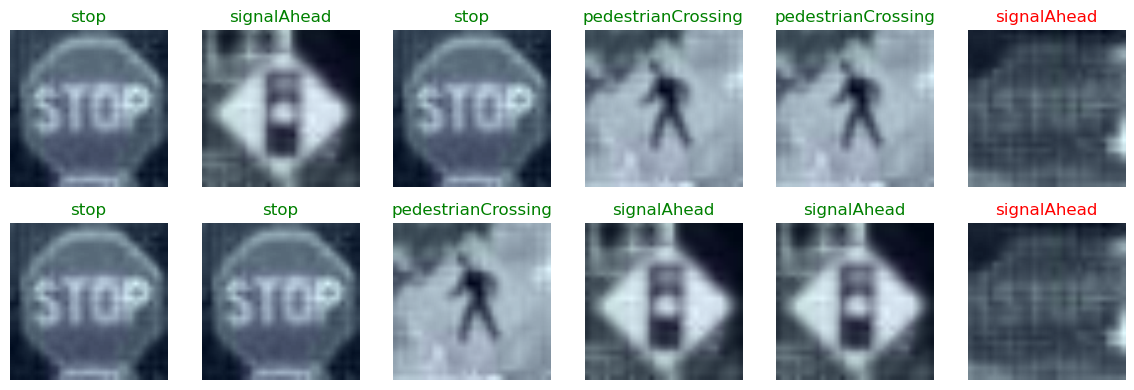

In [121]:
import matplotlib.pyplot as plt
import torch

fig = plt.figure(figsize=(12, 4))
indexes = []
rows, cols = 2, 6

for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    
    # Get the predicted label
    label_pred = torch.argmax(model(img_temp))

    # Add the subplot
    fig.add_subplot(rows, cols, i)
    
    # Permute the image tensor from (C, H, W) to (H, W, C)
    img = img.permute(1, 2, 0).cpu().numpy()  # Ensure the image is on CPU for matplotlib
    
    # Normalize the image to [0, 1] for proper visualization (if needed)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    
    # Display the image
    plt.imshow(img)  # No cmap='gray' for color images
    
    # Set the title color based on prediction correctness
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g')  # Correct prediction
    else:
        plt.title(class_names[label_pred], color='r')  # Incorrect prediction
    
    plt.axis(False)
    plt.tight_layout()

plt.show()

In [123]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [125]:
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

In [126]:
index = indexes[4]

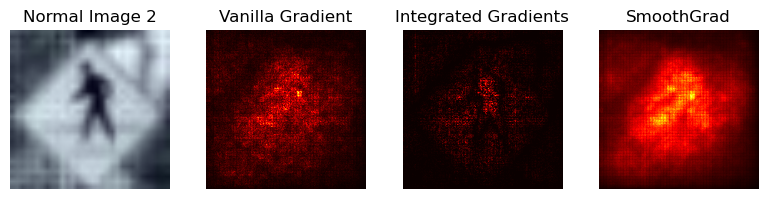

In [64]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_lisa_normal')

# Adversarial Training

In [130]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_adv.pth"
model_save_path = model_path / model_name
model_adv = resnet_18(filter='None', filter_layer=0)
model_adv.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [134]:
# Model to GPU and eval mode.
model_adv.to(device)
model_adv.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_adv, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET Adversarial is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET Adversarial is: 84.16%


In [136]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [138]:
# Applying explanation methods on the model outputs
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

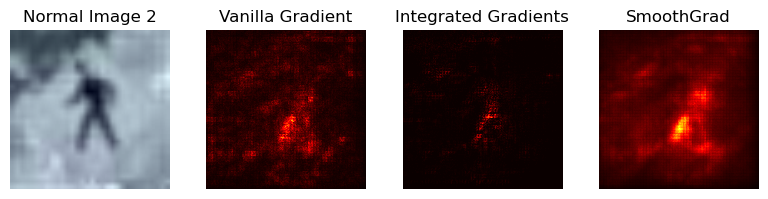

In [139]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_adv, a_batch_integrad_adv, a_batch_smoothgrad_adv, 'resnet_lisa_adversarial')

# L1 Pre Prune

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [92]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_l1_pre.pth"
model_save_path = model_path / model_name
model_l1_unstructured = resnet_18(filter='None', filter_layer=0)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"RESNET global sparsity = {compute_sparsity_resnet(model_l1_unstructured):.2f}%")
model_l1_unstructured.load_state_dict(torch.load(model_save_path))

RESNET global sparsity = 19.99%


<All keys matched successfully>

In [94]:
# Model to GPU and eval mode.
model_l1_unstructured.to(device)
model_l1_unstructured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_l1_unstructured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET Pruned L1 UnStructure Pre is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET Pruned L1 UnStructure Pre is: 97.07%


In [96]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [98]:
# Applying explanation methods on the model outputs
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

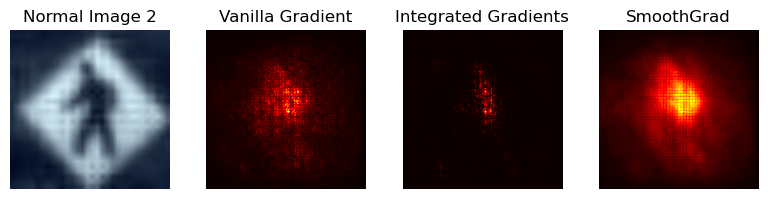

In [100]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_l1, a_batch_integrad_l1, a_batch_smoothgrad_l1, 'resnet_lisa_l1_pre')

# Post No Tune L1

In [103]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_l1_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_l1 =resnet_18(filter='None', filter_layer=0)

for name, module in model_no_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"RESNET global sparsity = {compute_sparsity_resnet(model_no_tuned_l1):.2f}%")
model_no_tuned_l1.load_state_dict(torch.load(model_save_path))

RESNET global sparsity = 19.99%


<All keys matched successfully>

In [105]:
# Model to GPU and eval mode.
model_no_tuned_l1.to(device)
model_no_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_l1, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET-16 Post no tune is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET-16 Post no tune is: 97.40%


In [107]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [109]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

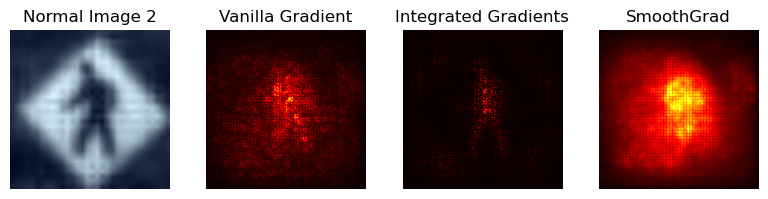

In [111]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_lisa_l1_post_no_tuned')

# Post Tuned l1

In [114]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_l1_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_l1 = resnet_18(filter='None', filter_layer=0)

for name, module in model_post_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"RESNET global sparsity = {compute_sparsity_resnet(model_post_tuned_l1):.2f}%")
model_post_tuned_l1.load_state_dict(torch.load(model_save_path))

RESNET global sparsity = 19.99%


<All keys matched successfully>

In [115]:
# Model to GPU and eval mode.
model_post_tuned_l1.to(device)
model_post_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_l1, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 96.75%


In [117]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [120]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

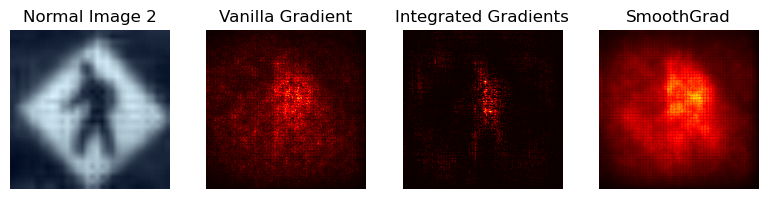

In [122]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_lisa_l1_post_tuned')

# Global Pre Prune

In [125]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_global_pre.pth"
model_save_path = model_path / model_name
model_global = resnet_18(filter='None', filter_layer=0)

parameters_to_prune = (
    (model_global.conv1, 'weight'),
    (model_global.bn1, 'weight'),
    (model_global.layer1[0].conv1, 'weight'),
    (model_global.layer1[0].bn1, 'weight'),
    (model_global.layer1[0].conv2, 'weight'),
    (model_global.layer1[0].bn2, 'weight'),
    (model_global.layer1[1].conv1, 'weight'),
    (model_global.layer1[1].bn1, 'weight'),
    (model_global.layer1[1].conv2, 'weight'),
    (model_global.layer1[1].bn2, 'weight'),
    (model_global.layer2[0].conv1, 'weight'),
    (model_global.layer2[0].bn1, 'weight'),
    (model_global.layer2[0].conv2, 'weight'),
    (model_global.layer2[0].bn2, 'weight'),
    (model_global.layer2[1].conv1, 'weight'),
    (model_global.layer2[1].bn1, 'weight'),
    (model_global.layer2[1].conv2, 'weight'),
    (model_global.layer2[1].bn2, 'weight'),
    (model_global.layer3[0].conv1, 'weight'),
    (model_global.layer3[0].bn1, 'weight'),
    (model_global.layer3[0].conv2, 'weight'),
    (model_global.layer3[0].bn2, 'weight'),
    (model_global.layer3[1].conv1, 'weight'),
    (model_global.layer3[1].bn1, 'weight'),
    (model_global.layer3[1].conv2, 'weight'),
    (model_global.layer3[1].bn2, 'weight'),
    (model_global.layer4[0].conv1, 'weight'),
    (model_global.layer4[0].bn1, 'weight'),
    (model_global.layer4[0].conv2, 'weight'),
    (model_global.layer4[0].bn2, 'weight'),
    (model_global.layer4[1].conv1, 'weight'),
    (model_global.layer4[1].bn1, 'weight'),
    (model_global.layer4[1].conv2, 'weight'),
    (model_global.layer4[1].bn2, 'weight'),
    (model_global.fc, 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET global sparsity = {compute_sparsity_resnet(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET global sparsity = 20.00%


<All keys matched successfully>

In [127]:
# Model to GPU and eval mode.
model_global.to(device)
model_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_global, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET Pruned Global Pre is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET Pruned Global Pre is: 96.10%


In [128]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [129]:
# Applying explanation methods on the model outputs
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

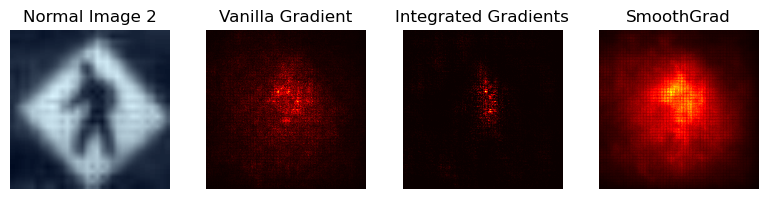

In [133]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_global, a_batch_integrad_global, a_batch_smoothgrad_global, 'resnet_lisa_global_pre')

# Global Post Prune No tune

In [136]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_global_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_global =resnet_18(filter='None', filter_layer=0)

parameters_to_prune = (
    (model_no_tuned_global.conv1, 'weight'),
    (model_no_tuned_global.bn1, 'weight'),
    (model_no_tuned_global.layer1[0].conv1, 'weight'),
    (model_no_tuned_global.layer1[0].bn1, 'weight'),
    (model_no_tuned_global.layer1[0].conv2, 'weight'),
    (model_no_tuned_global.layer1[0].bn2, 'weight'),
    (model_no_tuned_global.layer1[1].conv1, 'weight'),
    (model_no_tuned_global.layer1[1].bn1, 'weight'),
    (model_no_tuned_global.layer1[1].conv2, 'weight'),
    (model_no_tuned_global.layer1[1].bn2, 'weight'),
    (model_no_tuned_global.layer2[0].conv1, 'weight'),
    (model_no_tuned_global.layer2[0].bn1, 'weight'),
    (model_no_tuned_global.layer2[0].conv2, 'weight'),
    (model_no_tuned_global.layer2[0].bn2, 'weight'),
    (model_no_tuned_global.layer2[1].conv1, 'weight'),
    (model_no_tuned_global.layer2[1].bn1, 'weight'),
    (model_no_tuned_global.layer2[1].conv2, 'weight'),
    (model_no_tuned_global.layer2[1].bn2, 'weight'),
    (model_no_tuned_global.layer3[0].conv1, 'weight'),
    (model_no_tuned_global.layer3[0].bn1, 'weight'),
    (model_no_tuned_global.layer3[0].conv2, 'weight'),
    (model_no_tuned_global.layer3[0].bn2, 'weight'),
    (model_no_tuned_global.layer3[1].conv1, 'weight'),
    (model_no_tuned_global.layer3[1].bn1, 'weight'),
    (model_no_tuned_global.layer3[1].conv2, 'weight'),
    (model_no_tuned_global.layer3[1].bn2, 'weight'),
    (model_no_tuned_global.layer4[0].conv1, 'weight'),
    (model_no_tuned_global.layer4[0].bn1, 'weight'),
    (model_no_tuned_global.layer4[0].conv2, 'weight'),
    (model_no_tuned_global.layer4[0].bn2, 'weight'),
    (model_no_tuned_global.layer4[1].conv1, 'weight'),
    (model_no_tuned_global.layer4[1].bn1, 'weight'),
    (model_no_tuned_global.layer4[1].conv2, 'weight'),
    (model_no_tuned_global.layer4[1].bn2, 'weight'),
    (model_no_tuned_global.fc, 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity post no tune = {compute_sparsity_resnet(model_no_tuned_global):.2f}%")

model_no_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity post no tune = 20.00%


<All keys matched successfully>

In [138]:
# Model to GPU and eval mode.
model_no_tuned_global.to(device)
model_no_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET Post no tune is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET Post no tune is: 97.94%


In [139]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [140]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

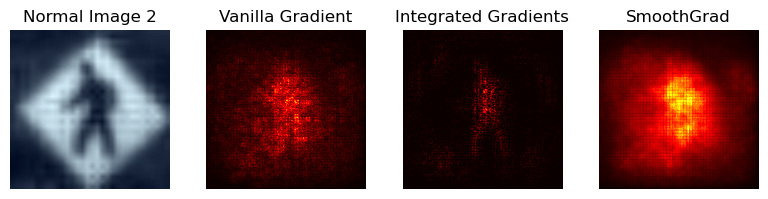

In [144]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_lisa_global_no_tune')

# Tuned Global

In [147]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_global_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_global = resnet_18(filter='None', filter_layer=0)

parameters_to_prune = (
    (model_post_tuned_global.conv1, 'weight'),
    (model_post_tuned_global.bn1, 'weight'),
    (model_post_tuned_global.layer1[0].conv1, 'weight'),
    (model_post_tuned_global.layer1[0].bn1, 'weight'),
    (model_post_tuned_global.layer1[0].conv2, 'weight'),
    (model_post_tuned_global.layer1[0].bn2, 'weight'),
    (model_post_tuned_global.layer1[1].conv1, 'weight'),
    (model_post_tuned_global.layer1[1].bn1, 'weight'),
    (model_post_tuned_global.layer1[1].conv2, 'weight'),
    (model_post_tuned_global.layer1[1].bn2, 'weight'),
    (model_post_tuned_global.layer2[0].conv1, 'weight'),
    (model_post_tuned_global.layer2[0].bn1, 'weight'),
    (model_post_tuned_global.layer2[0].conv2, 'weight'),
    (model_post_tuned_global.layer2[0].bn2, 'weight'),
    (model_post_tuned_global.layer2[1].conv1, 'weight'),
    (model_post_tuned_global.layer2[1].bn1, 'weight'),
    (model_post_tuned_global.layer2[1].conv2, 'weight'),
    (model_post_tuned_global.layer2[1].bn2, 'weight'),
    (model_post_tuned_global.layer3[0].conv1, 'weight'),
    (model_post_tuned_global.layer3[0].bn1, 'weight'),
    (model_post_tuned_global.layer3[0].conv2, 'weight'),
    (model_post_tuned_global.layer3[0].bn2, 'weight'),
    (model_post_tuned_global.layer3[1].conv1, 'weight'),
    (model_post_tuned_global.layer3[1].bn1, 'weight'),
    (model_post_tuned_global.layer3[1].conv2, 'weight'),
    (model_post_tuned_global.layer3[1].bn2, 'weight'),
    (model_post_tuned_global.layer4[0].conv1, 'weight'),
    (model_post_tuned_global.layer4[0].bn1, 'weight'),
    (model_post_tuned_global.layer4[0].conv2, 'weight'),
    (model_post_tuned_global.layer4[0].bn2, 'weight'),
    (model_post_tuned_global.layer4[1].conv1, 'weight'),
    (model_post_tuned_global.layer4[1].bn1, 'weight'),
    (model_post_tuned_global.layer4[1].conv2, 'weight'),
    (model_post_tuned_global.layer4[1].bn2, 'weight'),
    (model_post_tuned_global.fc, 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity post no tune = {compute_sparsity_resnet(model_post_tuned_global):.2f}%")

model_post_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity post no tune = 20.00%


<All keys matched successfully>

In [148]:
# Model to GPU and eval mode.
model_post_tuned_global.to(device)
model_post_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Global post tuned is: {(100 * test_acc):.2f}%")

Test accuracy for Global post tuned is: 98.81%


In [149]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [151]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

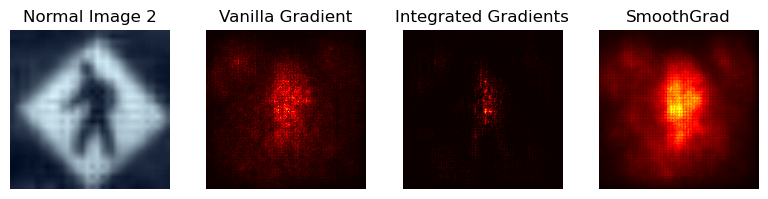

In [155]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_lisa_global_post_tuned')

# Layered Pre

In [158]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_layered_pre.pth"
model_save_path = model_path / model_name
model_structured = resnet_18(filter='None', filter_layer=0)

 # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer1[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer2[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer3[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.layer4[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)

prune.ln_structured(model_structured.fc, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"Resnet structrured sparsity = {compute_sparsity_resnet(model_structured):.2f}%")


model_structured.load_state_dict(torch.load(model_save_path))


Resnet structrured sparsity = 9.99%


<All keys matched successfully>

In [160]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET Pruned Pre Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET Pruned Pre Layered Structure is: 95.01%


In [161]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [162]:
# Applying explanation methods on the model outputs
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

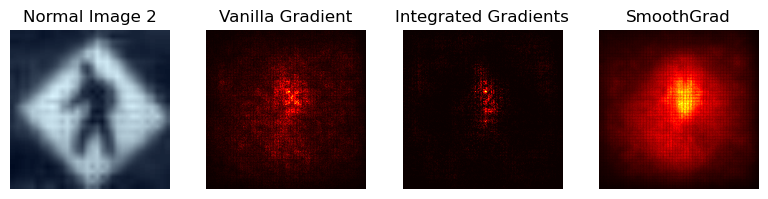

In [166]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_structured, a_batch_integrad_structured, a_batch_smoothgrad_structured, 'resnet_lisa_layered_pre')

# Layered Post No Tune

In [169]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_layered_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_layered = resnet_18(filter='None', filter_layer=0)
        
# Prune layer-wise in a structured manner-
prune.ln_structured(model_no_tuned_layered.conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer1[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer2[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer3[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.layer4[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)

prune.ln_structured(model_no_tuned_layered.fc, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"RESNET global sparsity = {compute_sparsity_resnet(model_no_tuned_layered):.2f}%")

model_no_tuned_layered.load_state_dict(torch.load(model_save_path))

RESNET global sparsity = 9.99%


<All keys matched successfully>

In [171]:
# Model to GPU and eval mode.
model_no_tuned_layered.to(device)
model_no_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET POST Layeredis: {(100 * test_acc):.2f}%")

Test accuracy for RESNET POST Layeredis: 89.05%


In [172]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [173]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

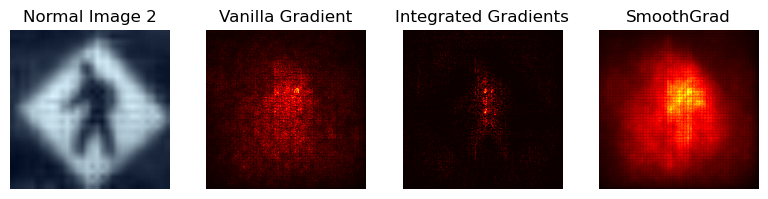

In [177]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_lisa_layered_no_tune')

# Layered Tuned

In [180]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "resnet_lisa_layered_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_layered = resnet_18(filter='None', filter_layer=0)
        
# Prune layer-wise in a structured manner-
prune.ln_structured(model_post_tuned_layered.conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer1[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer1[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer2[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer2[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer3[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer3[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[0].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[0].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[0].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[1].conv1, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.layer4[1].conv2, name = "weight", amount = 0.1, n = 2, dim = 0)
# prune.ln_structured(model.layer4[1].bn2, name = "weight", amount = 0.1, n = 2, dim = 0)

prune.ln_structured(model_post_tuned_layered.fc, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"RESNET global sparsity = {compute_sparsity_resnet(model_post_tuned_layered):.2f}%")

model_post_tuned_layered.load_state_dict(torch.load(model_save_path))

RESNET global sparsity = 9.99%


<All keys matched successfully>

In [182]:
# Model to GPU and eval mode.
model_post_tuned_layered.to(device)
model_post_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for RESNET Layered Tuned is: {(100 * test_acc):.2f}%")

Test accuracy for RESNET Layered Tuned is: 99.35%


In [183]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [184]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

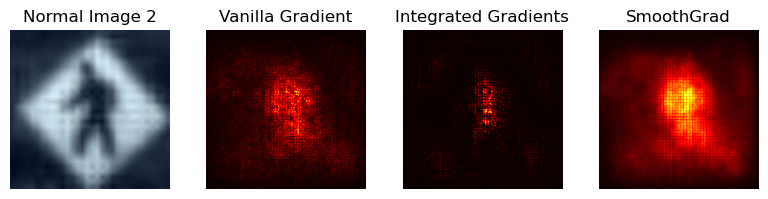

In [188]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'resnet_lisa_layered_post_tuned')

In [8]:
def explainer_wrapper(**kwargs):
    """
    A wrapper function to call the appropriate explanation method.

    """
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    """
    Generate explanations for a model's predictions using the SmoothGrad method.

    Args:
        model: The model to explain.
        inputs : Input samples.
        targets: Target labels corresponding to the inputs.
        abs : Whether to use the absolute value of gradients.
        normalise: Whether to normalize the explanation
        stdevs: Standard deviation of the noise added to inputs
        nt_samples: Number of noisy samples to generate for SmoothGrad.

    Returns:
        numpy.ndarray: Explanation maps for the input samples.
    """
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 224),kwargs.get("img_size", 224),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 224),
                kwargs.get("img_size", 224),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 224), kwargs.get("img_size", 224))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

In [9]:
xai_method=["SmoothGrad"]

In [10]:
gc.collect()
torch.cuda.empty_cache()

# ROAD VANILLA GRADIENT

In [16]:
result_normal = {1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(1.0), 31: np.float64(1.0), 41: np.float64(0.997983870967742), 51: np.float64(0.9928763440860215), 61: np.float64(0.9833255299372106), 71: np.float64(0.9544012267047705), 81: np.float64(0.8830946381905384), 91: np.float64(0.7213560666450216)}

result_adv = {1: np.float64(0.9859251561583193), 11: np.float64(0.9662080958791073), 21: np.float64(0.9460856328793896), 31: np.float64(0.9299334320736183), 41: np.float64(0.8980980269961754), 51: np.float64(0.8524330502198578), 61: np.float64(0.8028272390021632), 71: np.float64(0.7428053220240031), 81: np.float64(0.6476818433278784), 91: np.float64(0.4781232453936637)}

result_l1_pre ={1: np.float64(0.9989035087719298), 11: np.float64(0.9989035087719298), 21: np.float64(0.9978954442558008), 31: np.float64(0.9968873797396718), 41: np.float64(0.9948630550609412), 51: np.float64(0.9845858142007945), 61: np.float64(0.9631537195558292), 71: np.float64(0.9251212681182607), 81: np.float64(0.8219616032786351), 91: np.float64(0.6408980754468898)}

result_no_tuned_l1 ={1: np.float64(0.9979837398373984), 11: np.float64(0.9969420731707318), 21: np.float64(0.9959420731707317), 31: np.float64(0.9959420731707317), 41: np.float64(0.9928766326802613), 51: np.float64(0.9868111921897907), 61: np.float64(0.9775684187863317), 71: np.float64(0.9381958187057874), 81: np.float64(0.8804407396397236), 91: np.float64(0.7140241882162159)}

result_post_tuned_l1 ={1: np.float64(0.997983870967742), 11: np.float64(0.996983870967742), 21: np.float64(0.9959676108051403), 31: np.float64(0.9959676108051403), 41: np.float64(0.9939513506425387), 51: np.float64(0.989918961447679), 61: np.float64(0.976837922895358), 71: np.float64(0.9507406241804354), 81: np.float64(0.8864320744820351), 91: np.float64(0.7356363755573039)}

result_global_pre ={1: np.float64(0.9989495798319328), 11: np.float64(0.9989495798319328), 21: np.float64(0.9969252551532022), 31: np.float64(0.9969252551532022), 41: np.float64(0.9917502345984595), 51: np.float64(0.9804948810300741), 61: np.float64(0.9521038451637818), 71: np.float64(0.9070237508755874), 81: np.float64(0.8340509699948916), 91: np.float64(0.6925816281196195)}

result_no_tuned_global={1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(0.9989669421487604), 31: np.float64(0.9939177552652627), 41: np.float64(0.9869177552652627), 51: np.float64(0.9848597040789123), 61: np.float64(0.9544573165810218), 71: np.float64(0.9328089665385867), 81: np.float64(0.861914702868226), 91: np.float64(0.7157237599025581)}

result_post_tuned_global={1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(0.9990157480314961), 31: np.float64(0.9980236845394326), 41: np.float64(0.9920784960473691), 51: np.float64(0.9871413661182977), 61: np.float64(0.9673529226815398), 71: np.float64(0.9119492700131233), 81: np.float64(0.8248271173134608), 91: np.float64(0.6940061652449693)}

result_pre_tuned_layered={1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(0.9967201509363892), 31: np.float64(0.995669730768322), 41: np.float64(0.9863458120326933), 51: np.float64(0.981136462098483), 61: np.float64(0.965551477961308), 71: np.float64(0.9427244554565454), 81: np.float64(0.8748867776646398), 91: np.float64(0.6987896313495223)}

result_post_no_tuned_layered={1: np.float64(0.9949494949494949), 11: np.float64(0.9938625384277557), 21: np.float64(0.9902843032457471), 31: np.float64(0.9891973467240079), 41: np.float64(0.9847402810533403), 51: np.float64(0.9813377156122187), 61: np.float64(0.9587327342959943), 71: np.float64(0.9244500246613714), 81: np.float64(0.8421484661024694), 91: np.float64(0.6350176712526092)}

result_post_tuned_layered={1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(1.0), 31: np.float64(1.0), 41: np.float64(0.9980236845394326), 51: np.float64(0.9734208474842088), 61: np.float64(0.9548172663813659), 71: np.float64(0.9263156217552133), 81: np.float64(0.8652544396493708), 91: np.float64(0.7303705615524021)}


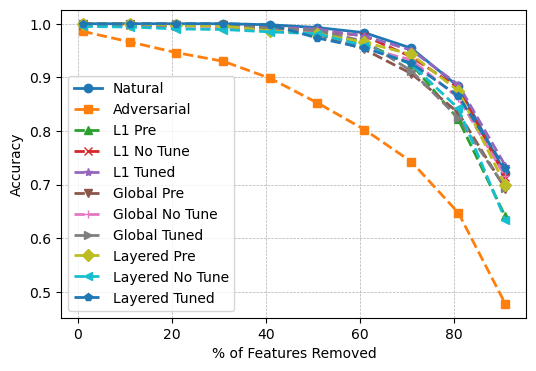

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='p', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_LISA_VANILLA_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD INTEGRATED GRADIENT

In [20]:
result_normal = {1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(1.0), 31: np.float64(1.0), 41: np.float64(1.0), 51: np.float64(1.0), 61: np.float64(1.0), 71: np.float64(0.998991935483871), 81: np.float64(0.9870696092465817), 91: np.float64(0.9749646394065606)}

result_adv = {1: np.float64(0.9792242797633633), 11: np.float64(0.9755902789932439), 21: np.float64(0.9755902789932439), 31: np.float64(0.9691443218975343), 41: np.float64(0.9679066981351581), 51: np.float64(0.9679066981351581), 61: np.float64(0.9667274528521392), 71: np.float64(0.9614228545977432), 81: np.float64(0.9552594002572314), 91: np.float64(0.9093778529929111)}

result_l1_pre = {1: np.float64(1.0), 11: np.float64(0.9989837398373984), 21: np.float64(0.9979916763453349), 31: np.float64(0.9979916763453349), 41: np.float64(0.9969586184940953), 51: np.float64(0.9979916763453349), 61: np.float64(0.9969586184940953), 71: np.float64(0.9949093004802539), 81: np.float64(0.9827437744566347), 91: np.float64(0.9562407924208092)}

result_no_tuned_l1 ={1: np.float64(0.9988425925925926), 11: np.float64(0.9988425925925926), 21: np.float64(0.9988425925925926), 31: np.float64(0.997826332429991), 41: np.float64(0.997826332429991), 51: np.float64(0.997826332429991), 61: np.float64(0.997826332429991), 71: np.float64(0.9957938121047878), 81: np.float64(0.9855704341357139), 91: np.float64(0.9720125889109031)}

result_post_tuned_l1 ={1: np.float64(1.0), 11: np.float64(0.9990079365079365), 21: np.float64(0.998015873015873), 31: np.float64(0.998015873015873), 41: np.float64(0.998015873015873), 51: np.float64(0.998015873015873), 61: np.float64(0.997007808499744), 71: np.float64(0.997007808499744), 81: np.float64(0.9909664301159903), 91: np.float64(0.9727332631933072)}

result_global_pre ={1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(0.9989669421487604), 31: np.float64(0.9989669421487604), 41: np.float64(0.9989669421487604), 51: np.float64(0.9989669421487604), 61: np.float64(0.9958667907978975), 71: np.float64(0.9894239436730726), 81: np.float64(0.9810868888345946), 91: np.float64(0.9582760107715388)}

result_no_tuned_global={1: np.float64(0.998991935483871), 11: np.float64(0.9979756753212693), 21: np.float64(0.9969676108051403), 31: np.float64(0.9969676108051403), 41: np.float64(0.9949432861264097), 51: np.float64(0.9949432861264097), 61: np.float64(0.9929271570941516), 71: np.float64(0.9919190925780226), 81: np.float64(0.985812516391293), 91: np.float64(0.9696783595134615)}

result_post_tuned_global={1: np.float64(1.0), 11: np.float64(0.9990157480314961), 21: np.float64(0.9990157480314961), 31: np.float64(0.9990157480314961), 41: np.float64(0.9990157480314961), 51: np.float64(0.9990157480314961), 61: np.float64(0.9980314960629921), 71: np.float64(0.9980314960629921), 81: np.float64(0.9990157480314961), 91: np.float64(0.987255043801907)}

result_pre_tuned_layered={1: np.float64(0.99875), 11: np.float64(0.99875), 21: np.float64(0.99875), 31: np.float64(0.9956139291089072), 41: np.float64(0.9891514176333094), 51: np.float64(0.9881009974652422), 61: np.float64(0.9870407735751731), 71: np.float64(0.9849643329906679), 81: np.float64(0.9781135803167117), 91: np.float64(0.9510825496237093)}

result_post_no_tuned_layered={1: np.float64(0.9906707501512402), 11: np.float64(0.9895931639443436), 21: np.float64(0.9863108380327074), 31: np.float64(0.9852424619643313), 41: np.float64(0.9852424619643313), 51: np.float64(0.9841459707362611), 61: np.float64(0.9819811034398149), 71: np.float64(0.9799886499364721), 81: np.float64(0.9754056984881956), 91: np.float64(0.9363773130096567)}

result_post_tuned_layered={1: np.float64(1.0), 11: np.float64(1.0), 21: np.float64(1.0), 31: np.float64(1.0), 41: np.float64(0.9970626230314961), 51: np.float64(0.9773257425418026), 61: np.float64(0.9694258672614916), 71: np.float64(0.9664652998324202), 81: np.float64(0.9664652998324202), 91: np.float64(0.9587048516192161)}


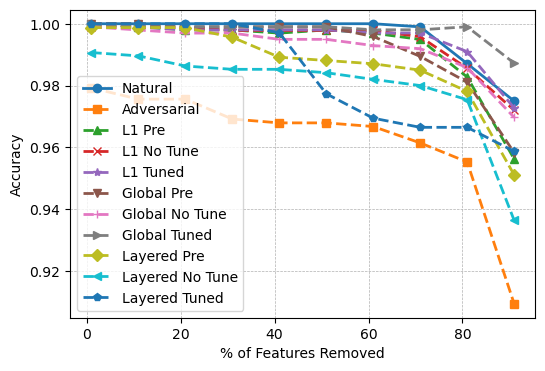

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='p', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_LISA__IG_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD SMOOTHGRAD

In [24]:
result_normal = {1: np.float64(1.0), 11: np.float64(0.9832030623142144), 21: np.float64(0.9495818148563554), 31: np.float64(0.8475249856089394), 41: np.float64(0.7410318616681824), 51: np.float64(0.6585473594732467), 61: np.float64(0.5374352873543552), 71: np.float64(0.424686909470851), 81: np.float64(0.280470969657265), 91: np.float64(0.18243249688463142)}

result_adv = {1: np.float64(0.9868129212805763), 11: np.float64(0.9161565936060224), 21: np.float64(0.7855809495535382), 31: np.float64(0.7002999980686967), 41: np.float64(0.6316778933928003), 51: np.float64(0.5625820889708377), 61: np.float64(0.547435677752953), 71: np.float64(0.48752773423153506), 81: np.float64(0.41373221670640536), 91: np.float64(0.34301562296648397)}

result_l1_pre = {1: np.float64(0.9977678571428572), 11: np.float64(0.9668394027183869), 21: np.float64(0.8979368544916775), 31: np.float64(0.7984218720657923), 41: np.float64(0.7031808691764944), 51: np.float64(0.626039236813283), 61: np.float64(0.5362152677839124), 71: np.float64(0.44630143309255793), 81: np.float64(0.3273624133269553), 91: np.float64(0.2270988914622334)}

result_no_tuned_l1 ={1: np.float64(1.0), 11: np.float64(0.9834369920492895), 21: np.float64(0.9370879046282313), 31: np.float64(0.8478941726990912), 41: np.float64(0.7506629674115596), 51: np.float64(0.6457070370631767), 61: np.float64(0.5215822833846039), 71: np.float64(0.43411184952471654), 81: np.float64(0.3166816253568311), 91: np.float64(0.21856643588108252)}

result_post_tuned_l1 ={1: np.float64(0.9979674796747968), 11: np.float64(0.9979674796747968), 21: np.float64(0.959577165292038), 31: np.float64(0.8941061187217113), 41: np.float64(0.8278554201477818), 51: np.float64(0.7231547459567405), 61: np.float64(0.6120965768196401), 71: np.float64(0.4794742233857242), 81: np.float64(0.3281788291574971), 91: np.float64(0.21821893375645246)}

result_global_pre ={1: np.float64(0.9979508196721312), 11: np.float64(0.9651743693806056), 21: np.float64(0.9292063216620768), 31: np.float64(0.844068848446446), 41: np.float64(0.7437846150835162), 51: np.float64(0.6597288111297236), 61: np.float64(0.5007163166486416), 71: np.float64(0.42800226796230256), 81: np.float64(0.3863064749139075), 91: np.float64(0.29716373393030554)}

result_no_tuned_global={1: np.float64(0.9988095238095238), 11: np.float64(0.9781262367320589), 21: np.float64(0.9305738977125679), 31: np.float64(0.8337934581809483), 41: np.float64(0.7274744050861282), 51: np.float64(0.6359692773132977), 61: np.float64(0.5191722353832897), 71: np.float64(0.43312464947850465), 81: np.float64(0.32105177415031855), 91: np.float64(0.20230547534029045)}

result_post_tuned_global={1: np.float64(1.0), 11: np.float64(0.9920047255555657), 21: np.float64(0.9041918817401726), 31: np.float64(0.844846926704307), 41: np.float64(0.7756044684175473), 51: np.float64(0.6799144754161011), 61: np.float64(0.5548861064017868), 71: np.float64(0.41628521068994095), 81: np.float64(0.29629028428926873), 91: np.float64(0.19702536950501184)}

result_pre_tuned_layered={1: np.float64(0.9987745098039216), 11: np.float64(0.9871409601455718), 21: np.float64(0.9285606612299369), 31: np.float64(0.8296399583211636), 41: np.float64(0.7476947721880106), 51: np.float64(0.6465641199256454), 61: np.float64(0.5617075428249837), 71: np.float64(0.47374632162245334), 81: np.float64(0.36836702180204656), 91: np.float64(0.17590133785153045)}

result_post_no_tuned_layered={1: np.float64(0.9951923076923077), 11: np.float64(0.9780492138222402), 21: np.float64(0.9391848869952351), 31: np.float64(0.8445848911101923), 41: np.float64(0.7324085886547459), 51: np.float64(0.6288216109224163), 61: np.float64(0.48877768374663355), 71: np.float64(0.39482155530406265), 81: np.float64(0.29408459860993064), 91: np.float64(0.18268338635868148)}

result_post_tuned_layered={1: np.float64(1.0), 11: np.float64(0.9990157480314961), 21: np.float64(0.9507261449124873), 31: np.float64(0.8897341166573227), 41: np.float64(0.812831683488532), 51: np.float64(0.6890929714132056), 61: np.float64(0.6052827264561673), 71: np.float64(0.4797996293646851), 81: np.float64(0.32559906581316855), 91: np.float64(0.19609495352647532)}


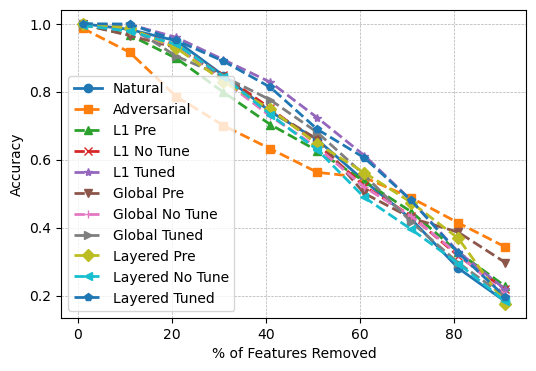

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='p', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/RESNET_LISA__SMOOTH_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# INPUT STABILITY

In [33]:
normal_input_saliency =-0.12576484267596832
normal_input_ig = 2.8464158969304174
normal_input_smooth = -0.8532284570426754

adversarial_input_saliency =  -0.19451437970474986
adversarial_input_ig = 2.791954894710761
adversarial_input_smooth = -0.9385503098009726

l1_pre_input_saliency = -0.1439056040728457
l1_pre_input_ig = 2.830037601490135
l1_pre_input_smooth =-0.8531456249157315

l1_post_no_tune_input_saliency =  -0.13975874095070542
l1_post_no_tune_input_ig =3.0748378015661535
l1_post_no_tune_input_smooth = -0.9268857496159579

l1_post_tune_input_saliency =  -0.1093275943426744
l1_post_tune_input_ig =  2.8263786692978967
l1_post_tune_input_smooth = -0.8887433870155002

global_pre_input_saliency = -0.15870471543097933
global_pre_input_ig = 2.742968767938694
global_pre_input_smooth = -0.9242497676695602

global_no_tune_input_saliency = -0.0697953016933587
global_no_tune_input_ig = 3.060053538740773
global_no_tune_input_smooth = -0.934093252155653

global_tune_input_saliency = -0.0889708372944047
global_tune_input_ig =3.1216098929012297
global_tune_input_smooth =  -0.8781541579928436

layered_pre_input_saliency =-0.10733675651266505
layered_pre_tune_input_ig = 2.875595992916024
layered_pre_tune_input_smooth =-0.936169868193471

layered_no_tune_input_saliency =-0.2382739935248777
layered_no_tune_input_ig =   2.7307681544950078
layered_no_tune_input_smooth =  -0.9603774750233977

layered_tune_input_saliency = -0.2075958916179139
layered_tune_input_ig =   3.247529507735414
layered_tune_input_smooth =-0.8867552100824664

In [35]:
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_pre_input_saliency, l1_post_no_tune_input_saliency, l1_post_tune_input_saliency,global_pre_input_saliency, global_no_tune_input_saliency,global_tune_input_saliency, layered_pre_input_saliency,layered_no_tune_input_saliency, layered_tune_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_pre_input_ig, l1_post_no_tune_input_ig, l1_post_tune_input_ig,global_pre_input_ig,global_no_tune_input_ig,global_tune_input_ig, layered_pre_tune_input_ig, layered_no_tune_input_ig, layered_tune_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_pre_input_smooth, l1_post_no_tune_input_smooth, l1_post_tune_input_smooth, global_pre_input_smooth, global_no_tune_input_smooth, global_tune_input_smooth, layered_pre_tune_input_smooth, layered_no_tune_input_smooth, layered_tune_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,-0.125765,2.846416,-0.853228
Adversarial Model,-0.194514,2.791955,-0.938550
L1 Pre Prune,-0.143906,2.830038,-0.853146
L1 No Tune Prune,-0.139759,3.074838,-0.926886
L1 Tuned Prune,-0.109328,2.826379,-0.888743
Global Pre Prune,-0.158705,2.742969,-0.924250
Global No Tune Prune,-0.069795,3.060054,-0.934093
Global Tuned Prune,-0.088971,3.121610,-0.878154
Layered Pre Prune,-0.107337,2.875596,-0.936170
Layered No Tune Prune,-0.238274,2.730768,-0.960377


# OUTPUT STABILITY

In [37]:
normal_output_saliency =2.1604621337876373
normal_output_ig =  5.136977401534716
normal_output_smooth =1.4467004720765657

adversarial_output_saliency = 2.3523548020467286
adversarial_output_ig = 5.234136979365664
adversarial_output_smooth =  1.4460796478750764

l1_pre_output_saliency =  2.287103591959772
l1_pre_output_ig =  5.441138947988373
l1_pre_output_smooth =  1.529582786546831

l1_post_no_tune_output_saliency =  2.241159711755117
l1_post_no_tune_output_ig =  5.3749102709361845
l1_post_no_tune_output_smooth =  1.433532393031033

l1_post_tune_output_saliency = 2.2530790117327766
l1_post_tune_output_ig = 5.252005496629757
l1_post_tune_output_smooth =  1.4324642111258652

global_pre_output_saliency =  2.316123517833431
global_pre_output_ig = 5.390248168905219
global_pre_output_smooth = 1.5035564837702922

global_no_tune_output_saliency =  2.453368970993352
global_no_tune_output_ig =  5.390931515141136
global_no_tune_output_smooth =  1.4545701951138879

global_tune_output_saliency = 2.3503620721172376
global_tune_output_ig = 5.403688209259359
global_tune_output_smooth = 1.6225754626068405

layered_pre_output_saliency = 2.152641394168384
layered_pre_tune_output_ig = 5.093134442325214
layered_pre_tune_output_smooth = 1.2315163214362594

layered_no_tune_output_saliency = 2.490744635739462
layered_no_tune_output_ig =  5.7492938676362675
layered_no_tune_output_smooth =   1.7423790464962894

layered_tune_output_saliency =2.348752487467296
layered_tune_output_ig =5.361880016929039
layered_tune_output_smooth = 1.5885413833715925

In [39]:
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_pre_output_saliency, l1_post_no_tune_output_saliency, l1_post_tune_output_saliency,global_pre_output_saliency, global_no_tune_output_saliency,global_tune_output_saliency, layered_pre_output_saliency,layered_no_tune_output_saliency, layered_tune_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_pre_output_ig, l1_post_no_tune_output_ig, l1_post_tune_output_ig,global_pre_output_ig,global_no_tune_output_ig,global_tune_output_ig, layered_pre_tune_output_ig, layered_no_tune_output_ig, layered_tune_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_pre_output_smooth, l1_post_no_tune_output_smooth, l1_post_tune_output_smooth, global_pre_output_smooth, global_no_tune_output_smooth, global_tune_output_smooth, layered_pre_tune_output_smooth, layered_no_tune_output_smooth, layered_tune_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,2.160462,5.136977,1.446700
Adversarial Model,2.352355,5.234137,1.446080
L1 Pre Prune,2.287104,5.441139,1.529583
L1 No Tune Prune,2.241160,5.374910,1.433532
L1 Tuned Prune,2.253079,5.252005,1.432464
Global Pre Prune,2.316124,5.390248,1.503556
Global No Tune Prune,2.453369,5.390932,1.454570
Global Tuned Prune,2.350362,5.403688,1.622575
Layered Pre Prune,2.152641,5.093134,1.231516
Layered No Tune Prune,2.490745,5.749294,1.742379


# SPARSITY 

In [41]:
normal_sparsity_saliency =0.4170028414919361
normal_sparsity_ig =0.5785993153031004
normal_sparsity_smooth =  0.3376552939063189

adversarial_sparsity_saliency = 0.3874664911428613
adversarial_sparsity_ig = 0.5711861510922713
adversarial_sparsity_smooth = 0.27783821462502456

l1_pre_sparsity_saliency =  0.4299719645659539
l1_pre_sparsity_ig =  0.5909877864936118
l1_pre_sparsity_smooth = 0.3541313838434089

l1_post_no_tune_sparsity_saliency =  0.4161140639676142
l1_post_no_tune_sparsity_ig =  0.5802942065430766
l1_post_no_tune_sparsity_smooth =   0.3334974139669049

l1_post_tune_sparsity_saliency =  0.40854728845331223
l1_post_tune_sparsity_ig =0.5778944975622181
l1_post_tune_sparsity_smooth =  0.3244008214299786

global_pre_sparsity_saliency =  0.4170028414919361
global_pre_sparsity_ig = 0.5785993153031004
global_pre_sparsity_smooth = 0.3376552939063189

global_no_tune_sparsity_saliency = 0.4156055635368039
global_no_tune_sparsity_ig =  0.5811351253375754
global_no_tune_sparsity_smooth = 0.33541367643968867

global_tune_sparsity_saliency =0.441497610270669
global_tune_sparsity_ig = 0.59985560288188
global_tune_sparsity_smooth =0.36546683591834667

layered_pre_sparsity_saliency =  0.40505943960711543
layered_pre_tune_sparsity_ig =  0.5745030897544801
layered_pre_tune_sparsity_smooth =  0.33061067909918945

layered_no_tune_sparsity_saliency =  0.4015917060177918
layered_no_tune_sparsity_ig = 0.5695811107533979
layered_no_tune_sparsity_smooth = 0.3159491544390822

layered_tune_sparsity_saliency = 0.41488489136722323
layered_tune_sparsity_ig =  0.5757799805311965
layered_tune_sparsity_smooth =  0.34078583636047116

In [43]:
vanilla_gradient = [normal_sparsity_saliency, adversarial_sparsity_saliency, l1_pre_sparsity_saliency, l1_post_no_tune_sparsity_saliency, l1_post_tune_sparsity_saliency,global_pre_sparsity_saliency, global_no_tune_sparsity_saliency,global_tune_sparsity_saliency, layered_pre_sparsity_saliency,layered_no_tune_sparsity_saliency, layered_tune_sparsity_saliency]
integrated_gradients = [normal_sparsity_ig, adversarial_sparsity_ig, l1_pre_sparsity_ig, l1_post_no_tune_sparsity_ig, l1_post_tune_sparsity_ig,global_pre_sparsity_ig,global_no_tune_sparsity_ig,global_tune_sparsity_ig, layered_pre_tune_sparsity_ig, layered_no_tune_sparsity_ig, layered_tune_sparsity_ig]
smoothgrad = [normal_sparsity_smooth, adversarial_sparsity_smooth, l1_pre_sparsity_smooth, l1_post_no_tune_sparsity_smooth, l1_post_tune_sparsity_smooth, global_pre_sparsity_smooth, global_no_tune_sparsity_smooth, global_tune_sparsity_smooth, layered_pre_tune_sparsity_smooth, layered_no_tune_sparsity_smooth, layered_tune_sparsity_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.417003,0.578599,0.337655
Adversarial Model,0.387466,0.571186,0.277838
L1 Pre Prune,0.429972,0.590988,0.354131
L1 No Tune Prune,0.416114,0.580294,0.333497
L1 Tuned Prune,0.408547,0.577894,0.324401
Global Pre Prune,0.417003,0.578599,0.337655
Global No Tune Prune,0.415606,0.581135,0.335414
Global Tuned Prune,0.441498,0.599856,0.365467
Layered Pre Prune,0.405059,0.574503,0.330611
Layered No Tune Prune,0.401592,0.569581,0.315949
